In [5]:
import numpy as np
import pandas as pd
from binance import Client
from dotenv import dotenv_values
from matplotlib import pyplot as plt



In [8]:

def get_history(symbol, interval, start, end = None):
    bars = client.get_historical_klines(symbol, interval, start_str=start, end_str=end, limit=1000)
    df = pd.DataFrame(bars)
    df["Date"] = pd.to_datetime(df.iloc[:,0], unit='ms')
    df.columns = [
        'Open time', 'open', 'high', 'low', 'close', 'volume', 'Clos time', 'quote asset volume', 'number of trades', 'taker buy asset volume',
        'taker buy quote asset volume', 'ignore', 'date'
    ]
    df = df[['date', 'open', 'high', 'low', 'close', 'volume']].copy()
    df.set_index('date', inplace=True)
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    df["returns"] = np.log(df.close.div(df.close.shift(1)))
    return df

In [14]:
def backtest(data, parameters, tc):
    # prepare features
    data = data[['close', 'volume', 'returns']].copy()
    data['vol_ch'] = np.log(data.volume.div(data.volume.shift(1)))
    data.loc[data.vol_ch > 3, 'vol_ch'] = np.nan
    data.loc[data.vol_ch < -3, 'vol_ch'] = np.nan
    
    # define trading positions
    return_thresh = np.percentile(data.returns.dropna(), parameters[0])
    cond1 = data.returns >= return_thresh
    volume_thresh = np.percentile(data.vol_ch.dropna(), [parameters[1], parameters[2]])
    cond2 = data.vol_ch.between(volume_thresh[0], volume_thresh[1])
    
    data['position'] = 1
    data.loc[cond1 & cond2, 'position'] = 0
    
    #backtest
    data['strategy'] = data.position.shift(1) * data['returns']
    data['trades'] = data.position.diff().fillna(0).abs()
    data.strategy = data.strategy + data.trades * tc
    data['creturns'] = data['returns'].cumsum().apply(np.exp)
    data['cstrategy'] =  data['strategy'].cumsum().apply(np.exp)
    
    return data.cstrategy[-1]

In [9]:
df = get_history(symbol='BTCUSDT', interval='1h', start='2021-01-01', end='2024-08-01')
df

,open,high,low,close,volume,returns
date,,,,,,
2021-01-01 00:00:00,28923.63,29031.34,28690.17,28995.13,2311.811445,NaN
2021-01-01 01:00:00,28995.13,29470.00,28960.35,29409.99,5403.068471,0.014207
2021-01-01 02:00:00,29410.00,29465.26,29120.03,29194.65,2384.231560,-0.007349
2021-01-01 03:00:00,29195.25,29367.00,29150.02,29278.40,1461.345077,0.002865
2021-01-01 04:00:00,29278.41,29395.00,29029.40,29220.31,2038.046803,-0.001986
...,...,...,...,...,...,...
2024-07-31 20:00:00,65256.83,65422.00,64543.57,64595.81,2050.405840,-0.010181
2024-07-31 21:00:00,64595.81,65136.04,64530.00,64978.00,1450.509230,0.005899
2024-07-31 22:00:00,64978.00,65058.00,64634.00,64980.01,730.428840,0.000031


In [11]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
return_amount = backtest(df, parameters=(90,5,20), tc = -0.00085)
return_amount

np.float64(1.3615182022748775)

In [16]:
return_range = range(85,98,1)
vol_low_range = range(2,16,1)
vol_high_range = range(16,35,1)

In [17]:
from itertools import product
combinations = list(product(return_range, vol_low_range, vol_high_range))

In [18]:
len(combinations)

3458

In [20]:
results = []

for combination in combinations:
    results.append(backtest(data=df, parameters=combination, tc = -0.00085))

In [21]:
results_df = pd.DataFrame(data=combinations, columns=['returns', 'vol_Low', 'vol_high'])
results_df['performance'] = results

In [22]:
results_df

,returns,vol_Low,vol_high,performance
0,85,2,16,1.171071
1,85,2,17,1.116900
2,85,2,18,0.958942
3,85,2,19,0.893800
4,85,2,20,0.854568
...,...,...,...,...
3453,97,15,30,1.620247
3454,97,15,31,1.614384
3455,97,15,32,1.587920
3456,97,15,33,1.538311


NameError: name 'plt' is not defined

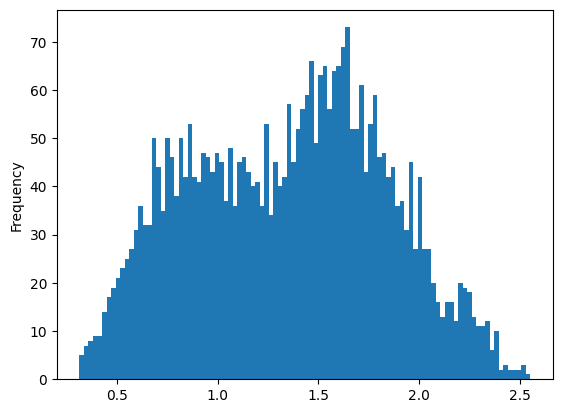

In [23]:
results_df.performance.plot(kind='hist', bins=100)
plt.show()

In [26]:
df['creturns'] = df['returns'].cumsum().apply(np.exp)
df['creturns'].iloc[-1]

np.float64(2.2295433750426557)

In [27]:
results_df.nlargest(20, 'performance')

,returns,vol_Low,vol_high,performance
2584,94,12,16,2.552685
2603,94,13,16,2.523355
2585,94,12,17,2.521312
2850,95,12,16,2.516088
2604,94,13,17,2.492342
2851,95,12,17,2.489717
2318,93,12,16,2.484260
2869,95,13,16,2.470990
2870,95,13,17,2.445091
2319,93,12,17,2.443599


In [15]:
from itertools import product

class LongBacktester():
    def __init__(self, symbol, start,end, tc = -0.00085,  interval = '1h'):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.interval = interval
        
        self.data = self.get_data()
        self.tp_year = (self.data.close.count()) / ((self.data.index[-1] - self.data.index[0]).days / 365)
        
    def __repr__(self):
        return f"LongBacktester(symbol = {self.symbol} | start = {self.start} | end = {self.end})"
    
    def get_data(self):
        config = dotenv_values(".env")
        client = Client(api_key=config['BINANCE_KEY'], api_secret=config['BINANCE_SECRET'])
        raw = client.get_historical_klines(self.symbol, self.interval, start_str=self.start, end_str=self.end, limit=1000)
        df = pd.DataFrame(raw)
        df["date"] = pd.to_datetime(df.iloc[:,0], unit='ms')
        df.columns = [
            'Open time', 'open', 'high', 'low', 'close', 'volume', 'Clos time', 'quote asset volume', 'number of trades', 'taker buy asset volume',
            'taker buy quote asset volume', 'ignore', 'date'
        ]
        df = df[['date', 'open', 'high', 'low', 'close', 'volume']].copy()
        df.set_index('date', inplace=True)
        for column in df.columns:
            df[column] = pd.to_numeric(df[column], errors='coerce')
        df["returns"] = np.log(df.close.div(df.close.shift(1)))
        return df
        
    def backtest(self, data, parameters, tc):
        # prepare features
        data = data[['close', 'volume', 'returns']].copy()
        data['vol_ch'] = np.log(data.volume.div(data.volume.shift(1)))
        data.loc[data.vol_ch > 3, 'vol_ch'] = np.nan
        data.loc[data.vol_ch < -3, 'vol_ch'] = np.nan
        
        # define trading positions
        return_thresh = np.percentile(data.returns.dropna(), parameters[0])
        cond1 = data.returns >= return_thresh
        volume_thresh = np.percentile(data.vol_ch.dropna(), [parameters[1], parameters[2]])
        cond2 = data.vol_ch.between(volume_thresh[0], volume_thresh[1])
        
        data['position'] = 1
        data.loc[cond1 & cond2, 'position'] = 0
        
        #backtest
        data['strategy'] = data.position.shift(1) * data['returns']
        data['trades'] = data.position.diff().fillna(0).abs()
        data.strategy = data.strategy + data.trades * tc
        data['creturns'] = data['returns'].cumsum().apply(np.exp)
        data['cstrategy'] =  data['strategy'].cumsum().apply(np.exp)
        return data.cstrategy[-1]
    
    def test_strategy(self, percentiles = None, thresh = None):
        self.prepare_data(self, percentiles, thresh)
        self.run_backtest()
        
        data = self.results.copy()
        data['creturns'] = data['returns'].cumsum().apply(np.exp)
        data['cstrategy'] =  data['strategy'].cumsum().apply(np.exp)
        self.results = data
        self.print_performance()
        
    def prepare_data(self, percentiles, thresh):
        data = self.data[['close', 'volume', 'returns']].copy()
        data['vol_ch'] = np.log(data.volume.div(data.volume.shift(1)))
        data.loc[data.vol_ch > 3, 'vol_ch'] = np.nan
        data.loc[data.vol_ch < -3, 'vol_ch'] = np.nan
        
        if percentiles:
            self.return_thresh = np.percentile(data.returns.dropna(), percentiles[0])
            self.volume_thresh = np.percentile(data.vol_ch.dropna(), percentiles[1], percentiles[2])
        elif thresh:
            self.return_thresh = thresh[0]
            self.volume_thresh = [thresh[1], thresh[2]]
            
        cond1 = data.returns >= self.return_thresh
        cond2 = data.vol_ch.between(self.volume_thresh[0], self.volume_thresh[1])
        
        data['position'] = 1
        data.loc[cond1 & cond2, 'position'] = 0
        self.results = data
        
    def run_backtest(self):
        data = self.results.copy()
        data['strategy'] = data.position.shift(1) * data['returns']
        data['trades'] = data.position.diff().fillna(0).abs()
        data.strategy = data.strategy + data.trades * self.tc
        
        self.results = data
        
    def plot_results(self):
       if self.results is None:
           print('Run test_strategy() first')
       else:
           title = f"{self.symbol} | TC = {self.tc}"
           self.results[['creturns', 'cstrategy']].plot(title = title, figsize = (12, 8))
    
    def optimize_strategy(self, return_range, vol_low_range, vol_high_range, metric = "Multiple"):
        combinations = list(product(return_range, vol_low_range, vol_high_range))
        results = []

        for combination in combinations:
            results.append(self.backtest(data=self.data, parameters=combination, tc = -0.00085))
            results_df = pd.DataFrame(data=combinations, columns=['returns', 'vol_Low', 'vol_high'])
        results_df['performance'] = results
            
        return results_df
    
    def print_performance(self):
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple       = round(self.calculate_multiple(data.returns), 6)
        outperformance = round(strategy_multiple-bh_multiple, 6)
        cagr = round(self.calculcate_cagr(data.strategy), 6)
        ann_mean = round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std = round(self.calculate_annualized_std(data.strategy), 6)
        sharpre = round(self.calculate_sharpe(data.strategy), 6)
        
        print(100*'=')
        print(f"SIMPLE PRICE&VOLUME STRATEGY | INSTRUMENT {self.symbol} | THRESHOLDS = {self.volume_thresh}, {self.return_thresh}")
        print(100*'-')
        print('PERFORMANCE MEASURES: ')
        print('\n')
        print(f"Multiple Strategy: {strategy_multiple}")
        print(f"Multiple (HODL): {bh_multiple}")
        print(38*'-')
        print(f"Out/Underperformance: {outperformance}")
        print('\n')
        print(f"CAGR: {cagr}")
        print(f"Annualized Mean: {ann_mean}")
        print(f"Annualized Std: {ann_std}")
        print(f"Sharpe Ratio: {sharpre}")
        print('\n')
        
    def calculate_multiple(self, series):
        return np.exp(series(sum))
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0].days)/ 365.25))-1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return self.calculate_cagr(series) / self.calculate_annualized_std(series)
        
        
        

In [10]:
tester = LongBacktester(symbol='BTCUSDT', start='2023-01-01', end='2024-01-01')

In [12]:
tester.data

,open,high,low,close,volume,returns
date,,,,,,
2023-01-01 00:00:00,16541.77,16545.70,16508.39,16529.67,4364.83570,NaN
2023-01-01 01:00:00,16529.59,16556.80,16525.78,16551.47,3590.06669,0.001318
2023-01-01 02:00:00,16551.47,16559.77,16538.14,16548.19,3318.84038,-0.000198
2023-01-01 03:00:00,16548.19,16548.19,16518.21,16533.04,4242.08050,-0.000916
2023-01-01 04:00:00,16533.04,16535.97,16511.92,16521.85,4285.00909,-0.000677
...,...,...,...,...,...,...
2023-12-31 20:00:00,42619.04,42680.36,42504.56,42558.01,1015.14035,-0.001433
2023-12-31 21:00:00,42558.02,42670.44,42520.72,42520.72,923.43813,-0.000877
2023-12-31 22:00:00,42520.73,42591.10,42056.00,42257.88,1811.59411,-0.006201


In [13]:
tester.tp_year

np.float64(8760.0)

In [16]:
tester = LongBacktester('BTCUSDT', start='2023-01-01', end='2024-01-01')
tester.optimize_strategy(return_range=(85,98,1), vol_low_range=(2,16,1), vol_high_range=(16,35,1))

C:\code\crypto-trading-neural-networks-algorythms\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\grigo\AppData\Local\Temp\ipykernel_11588\1541099484.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return data.cstrategy[-1]
C:\code\crypto-trading-neural-networks-algorythms\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\grigo\AppData\Local\Temp\ipykernel_11588\1541099484.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

,returns,vol_Low,vol_high,performance
0,85,2,16,1.884094
1,85,2,35,1.306752
2,85,2,1,2.569636
3,85,16,16,2.569636
4,85,16,35,1.752181
5,85,16,1,2.569636
6,85,1,16,1.900363
7,85,1,35,1.318035
8,85,1,1,2.569636
9,98,2,16,2.569515


In [17]:
tester.print_performance()

AttributeError: 'NoneType' object has no attribute 'copy'

In [18]:
tester = LongBacktester('BTCUSDT', start='2023-01-01', end='2024-01-01')
tester.test_strategy(percentiles = (90, 5, 20))

TypeError: LongBacktester.prepare_data() takes 3 positional arguments but 4 were given